In [3]:
import torch
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

**Dataset and Dataloader**

In [4]:
import sys
from torch.utils.data import random_split
sys.path.append('../')  # Adjust the path accordingly

from VQA_Dataset_BLIP import VQA_Dataset_preloaded
from transformers import BlipProcessor, BlipImageProcessor, BlipForQuestionAnswering

text_processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
image_processor = BlipImageProcessor.from_pretrained("Salesforce/blip-vqa-base")
model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")

model.to(device)
datasetLoaded = VQA_Dataset_preloaded(device)
datasetLoaded.load(fileName="embeddingsBLIPWithMultipleChoiceImageSize384Length11_4k.h5")

In [3]:
#Split
train_size = int(len(datasetLoaded)*0.8)
val_size = int(len(datasetLoaded)*0.1)
test_size = int(len(datasetLoaded))-train_size-val_size
generator = torch.Generator().manual_seed(1)
train_dataset, val_dataset, test_dataset = random_split(datasetLoaded, [train_size, val_size, test_size], generator=generator)
print("Train size: ", train_size)
print("Test size: ", test_size)

Train size:  3200
Test size:  400


In [4]:
#Dataloader
def collate_fn(batch):
    input_ids = [item['input_ids'] for item in batch]
    pixel_values = [item['pixel_values'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    labels = [item['labels'] for item in batch]
    multiple_choices = [item['answer_choices'] for item in batch]
    # create new batch
    batch = {}
    batch['input_ids'] = torch.stack(input_ids)
    batch['attention_mask'] = torch.stack(attention_mask)
    batch['pixel_values'] = torch.stack(pixel_values)
    batch['labels'] = torch.stack(labels)

    return batch, torch.stack(multiple_choices)

batch_size = 2
train_dataloader = DataLoader(train_dataset,
                              collate_fn=collate_fn,
                              batch_size=batch_size,
                              shuffle=False)
val_dataloader = DataLoader(val_dataset,
                            collate_fn=collate_fn,
                            batch_size=batch_size,
                            shuffle=False)

c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\transformers\generation\utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


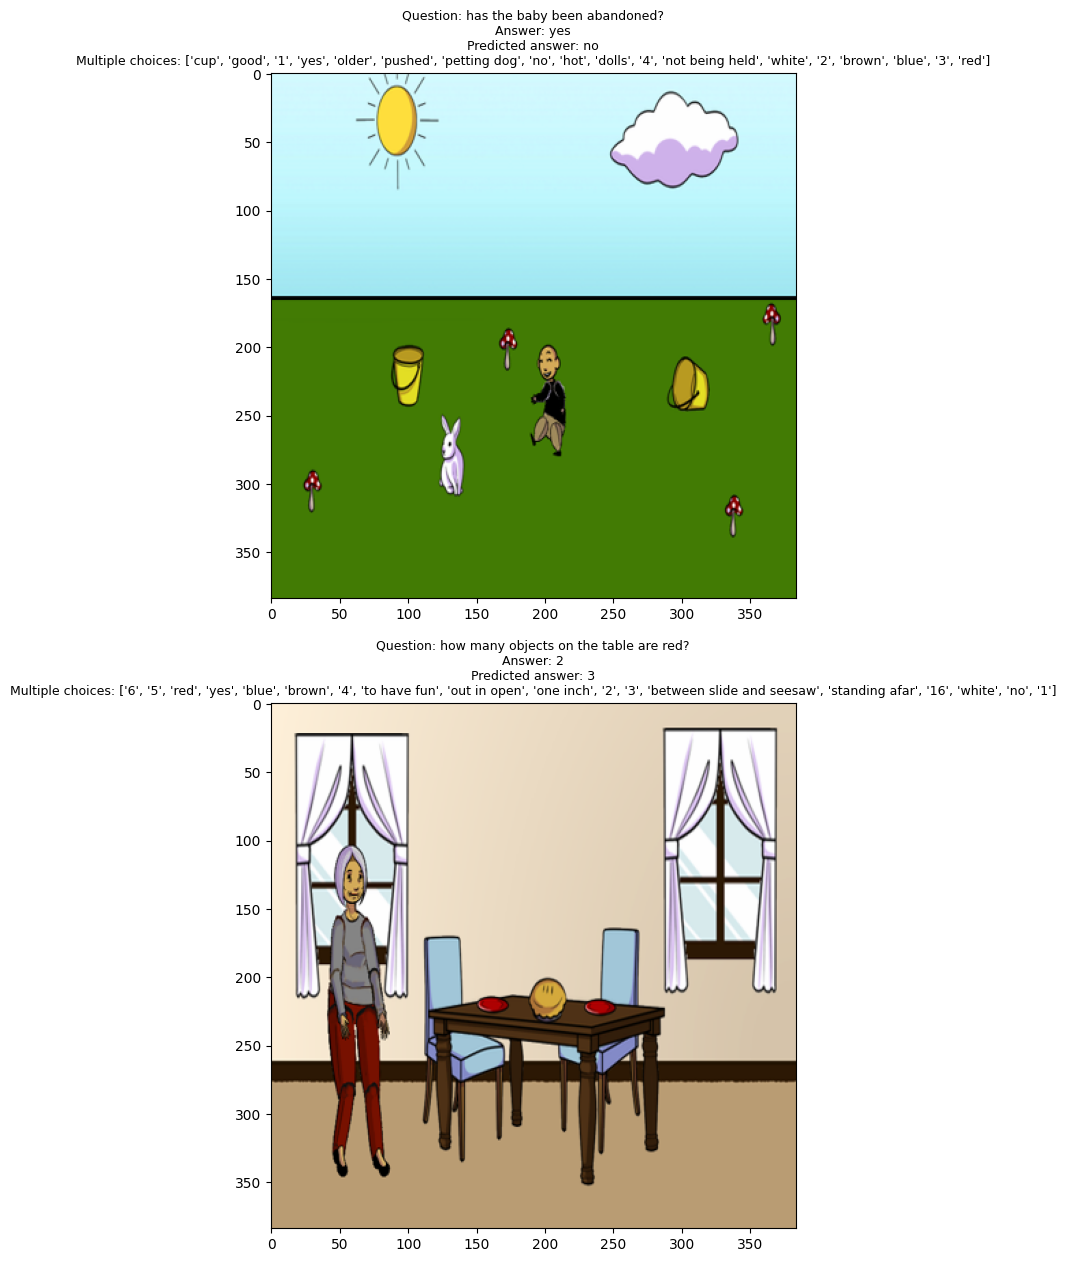

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image

image_mean = image_processor.image_mean
image_std = image_processor.image_std

#Checking data
fig=plt.figure(0, (28, 15))

element, multiple_choices = next(iter(train_dataloader))
outputs = model.generate(**element)

for i in range(batch_size):
    ax = fig.add_subplot(2,int(batch_size/2),i+1)
    
    img_tensor = element["pixel_values"][i].squeeze(0)
    unnormalized_image = (img_tensor.cpu().numpy() * np.array(image_std)[:, None, None]) + np.array(image_mean)[:, None, None]
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    
    question = text_processor.decode(element["input_ids"][i], skip_special_tokens=True)
    answer = text_processor.decode(element["labels"][i], skip_special_tokens=True)
    
    predicted_answer = text_processor.decode(outputs[i],skip_special_tokens=True)
    multiple_choices_text = text_processor.batch_decode(multiple_choices[i],skip_special_tokens=True)

    ax.imshow(Image.fromarray(unnormalized_image)) #Converting to matplotlib format
    ax.set_title("Question: "+question+"\nAnswer: "+str(answer)+"\nPredicted answer: "+predicted_answer+
                 "\nMultiple choices: "+str(multiple_choices_text), fontsize=9)
    

**Evaluating model without training**

In [6]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for element,_ in pbar:       
            outputs = model.generate(**element)
            correct_answers = text_processor.batch_decode(element["labels"], skip_special_tokens=True)
            predicted_answers = text_processor.batch_decode(outputs,skip_special_tokens=True)
            
            correct += sum(pred_answer == correct_answer for pred_answer, correct_answer in zip(predicted_answers, correct_answers))
            #print(predicted_answers, correct_answers)
            #print(correct)
            #print(element)
            #print(correct_answers)
            #break
                
    correct /= size
    return 100*correct

#eval(train_dataloader, model) #35.3125%, after increasing image size from 256 to 384: 50.312
#52.125 using 4k dataset

**Transfer learning for Multiple choice VQA**

1. Bleu score as a help for blip

In [7]:
from nltk.translate.bleu_score import sentence_bleu #n-gran: series of n tokens
import numpy as np

reference = [['this', 'is', 'small', 'test']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 3/4
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=np.exp(1-4/4) #Brevity penalty: candidate is not longer than reference, then formula
cum_2_gram = bp*np.exp(0.5*np.log(3/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)), " Manually: ", cum_2_gram)

#More references
reference = [['this', 'is', 'small', 'test'], ['this', 'small', 'test', 'a']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 4/4
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=1 #Brevity penalty: reference is not longer than candidate, then 1
cum_2_gram = bp*np.exp(0.5*np.log(4/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)), " Manually: ", cum_2_gram)

#Larger reference
reference = [['this', 'is', 'small', 'test','jaja']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 3/4*exp(1-5/4)
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3*exp(1-5/4)
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=np.exp(1-5/4) #Brevity penalty: reference is longer than candidate, then formula
cum_2_gram = bp*np.exp(0.5*np.log(3/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0)), " Manually: ", cum_2_gram)

#Larger candidate
reference = [['this', 'is', 'small']]
candidate = ['this', 'is', 'a', 'test']
print("1-gram", sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))) # 2/4*1
print("2-gram", sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))) # 1/3*1
print("3-gram", sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))) # 0

bp=1 #Brevity penalty: reference is not longer than candidate, then 1
cum_2_gram = bp*np.exp(0.5*np.log(2/4)+0.5*np.log(1/3))
print("Cumulative 2-gram", sentence_bleu(reference, candidate, weights=[(0.5, 0.5, 0, 0)]), " Manually: ", cum_2_gram)

1-gram 0.75
2-gram 0.3333333333333333
3-gram 2.2250738585072626e-308
Cumulative 2-gram 0.49999999999999994  Manually:  0.49999999999999994
1-gram 1.0
2-gram 0.3333333333333333
3-gram 2.2250738585072626e-308
Cumulative 2-gram 0.5773502691896257  Manually:  0.5773502691896257
1-gram 0.5841005873035536
2-gram 0.2596002610238016
3-gram 1.7328892633971685e-308
Cumulative 2-gram 0.3894003915357024  Manually:  0.3894003915357024
1-gram 0.5
2-gram 0.3333333333333333
3-gram 2.2250738585072626e-308
Cumulative 2-gram 0.408248290463863  Manually:  0.408248290463863


c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\Zetans\AppData\Local\Programs\Python\Python39\lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [8]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('corpus')
class ModelPlusBLEU(torch.nn.Module):
    def __init__(self, model, device):
        super().__init__()
        self.model = model
        self.device = device

    def forward(self, inputs, multiple_answers):
        blip_output = model.generate(**inputs)
        candidate_answers = text_processor.batch_decode(blip_output,skip_special_tokens=True)
        multiple_answers_batch = [text_processor.batch_decode(answer,skip_special_tokens=True) for answer in multiple_answers]
        predicted_answers = []

        for candidate_answer, multiple_answers in zip(candidate_answers, multiple_answers_batch):
            num_words_candidate = len(candidate_answer.split(" "))
            weights = ([1.0/num_words_candidate]*num_words_candidate)
            
            bleu_scores=[]
            for answer in multiple_answers:
                answer_tokens = [nltk.tokenize.word_tokenize(answer)]
                candidate_answer_tokens = nltk.tokenize.word_tokenize(candidate_answer)
                bleu_scores.append(sentence_bleu(answer_tokens, candidate_answer_tokens, weights=weights))
            
            #bleu_scores = np.ndarray([sentence_bleu([nltk.tokenize.word_tokenize(answer)], nltk.tokenize.word_tokenize(candidate_answer), weights=weights) ])    
            if [0]*18!=bleu_scores:
                predicted_answers.append(multiple_answers[np.argmax(bleu_scores)])
            else:
                predicted_answers.append(None)
            #print(bleu_scores)
            #print("Raw output: ", candidate_answer, "-Answers: ", multiple_answers)
        
        #print("Corrected output: ", predicted_answers)
        #print("")
        return predicted_answers
modelBleu = ModelPlusBLEU(model, device)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Zetans\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Zetans\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading corpus: Package 'corpus' not found in index


In [9]:
import tqdm
#Evaluating raw model
def eval(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    correct = 0
    pbar = tqdm.tqdm(dataloader)
    with torch.no_grad():
        for data, multiple_choices in pbar:             
            predicted_answers = modelBleu(data, multiple_choices)         
            
            correct_answers = text_processor.batch_decode(data["labels"], skip_special_tokens=True)
            
            correct += sum(pred_answer == correct_answer for pred_answer, correct_answer in zip(predicted_answers, correct_answers))
            #print(predicted_answers, correct_answers)
            #print(correct)
                
    correct /= size
    return 100*correct

#eval(train_dataloader, modelBleu) #After increasing image size from 256 to 384: 52.5
#54.03 using 4k dataset